## Generating and Visualizing Antipodal Grasps on Book

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import trimesh
import sys
from typing import List 
from IPython.display import clear_output
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    Concatenate,
    DiagramBuilder,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Parser,
    PointCloud,
    RigidTransform,
    StartMeshcat,
    UniformlyRandomRotationMatrix,
    Context,
    Diagram,
    PointCloud,
    Simulator,
    TrajectorySource,
    Solve,
    RotationMatrix,
    MultibodyPlant,
    eq,
    StateInterpolatorWithDiscreteDerivative,
    MinimumDistanceLowerBoundConstraint,
    RollPitchYaw,
    SolutionResult,
    CollisionFilterDeclaration,
    GeometrySet,
    Role,
)
from pydrake.geometry import Meshcat
from pydrake.multibody import inverse_kinematics

from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation import running_as_notebook
from manipulation.scenarios import AddFloatingRpyJoint, AddRgbdSensors, ycb, AddMultibodyTriad, MakeManipulationStation
from manipulation.utils import ConfigureParser
from manipulation.clutter import GraspCandidateCost, GenerateAntipodalGraspCandidate
from manipulation.icp import IterativeClosestPoint
from manipulation.pick import (
    MakeGripperCommandTrajectory,
    MakeGripperFrames,
    MakeGripperPoseTrajectory,
)
# Own utils
from hwstation.utils import init_diagram, fix_input_port, visualize_diagram, filterCollsionGeometry, get_iiwa_joint_state
from hwstation.add_objects import *
from perception.icp import run_table_book_icp, check_quality_of_icp
from rrt.rrt_planning import *
from grasp.grasping import *

from enum import Enum
import pandas as pd

from manipulation.station import MakeHardwareStation, load_scenario
from manipulation.station import AddPointClouds
from random import random
from manipulation.pick import *
#from manipulation.pick import *

## 1. Setup environment

In [7]:
# Start meshcat
try:
    meshcat = Meshcat(7005)
except:
    pass #This error appears if this cell is executed twice (port 7006 is already taken then)

scenario_data = get_library_scenario_data()
diagram_plan, visualizer, simulator = init_diagram(meshcat, scenario_data)
fix_input_port(diagram_plan, simulator)
diagram_plan_context = diagram_plan.CreateDefaultContext()
scene_graph = diagram_plan.GetSubsystemByName("station").GetSubsystemByName("scene_graph")
sg_context = scene_graph.GetMyContextFromRoot(diagram_plan_context)
filterCollsionGeometry(scene_graph, sg_context)
q0_init = get_iiwa_joint_state(diagram_plan, diagram_plan_context)
simulator.AdvanceTo(1.0)
diagram_plan_context = simulator.get_mutable_context()


Station input port size:  <pydrake.systems.framework.InputPort object at 0x7fff8c9b5bb0>
plant.GetStateNames():  154
plant.GetActuatorNames():  12
Fixing input port of size:  20
Fixing input port of size:  1


==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html



## 2. Running ICP to find point cloud

In [5]:
from perception.icp import *

In [11]:
merged_pointcloud = get_merged_pointcloud(diagram_plan_context,diagram_plan)

In [15]:
pcloud = merged_pointcloud.xyzs().transpose()

In [17]:
from sklearn.cluster import KMeans

In [28]:
plant = diagram_plan.GetSubsystemByName("station").GetSubsystemByName("plant")

In [38]:
plant_context = plant.GetMyContextFromRoot(diagram_plan_context)
table_frame = plant.GetFrameByName("table")
table_frame = table_frame.CalcPoseInWorld(plant_context)

In [43]:
length_table = 1.4
start = table_frame.translation()
end = start.copy()
end[0] = end[0] + length_table
k_init = np.linspace(start,end,10)

In [44]:
kmeans = KMeans(n_clusters=10, init = k_init) 

In [45]:
predict = kmeans.fit_predict(pcloud)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


In [46]:
import matplotlib.pyplot as plt

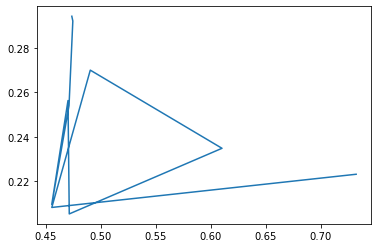

In [47]:
plt.plot(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1])

In [22]:
predict

array([1, 6, 6, ..., 2, 7, 9], dtype=int32)

In [20]:
kmeans.fit(pcloud)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
udp_read_packet -- select:: Interrupted system call
udp_read_packet -- select:: Interrupted system call
udp_read_packet -- select:: Interrupted system call
udp_read_packet -- select:: Interrupted system call
udp_read_packet -- select:: Interrupted system call
udp_read_packet -- select:: Interrupted system call


KMeans(n_clusters=10)

In [ ]:
kmeans.predict()

In [5]:
icp_cloud, X_MS_hat = run_table_book_icp(diagram_plan, diagram_plan_context, meshcat)